# Spatial Temporal Clustering of 2019 Teil Quake Tweets
---

In order to cluster the 2019 Teil Quake Tweets, we use ST-DBSCAN algorithm, a spatial-temporal clustering algorithm that is based on the DBSCAN algorithm augmented with a temporal parameter.

We have used the following implementation [ST-DBSCAN](https://github.com/eren-ck/st_dbscan).
> **Keywords** Data mining, Cluster analysis, Spatial–temporal data, Cluster visualization

### Importing libraries

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
from pathlib import Path
from cycler import cycler
from st_dbscan import ST_DBSCAN
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from py_module.utils import create_hulls, plot_cube_hulls

# Ignore warnings
warnings.filterwarnings('ignore')

# Set numpy print options
np.set_printoptions(precision=3, suppress=True)

# Set up matplotlib rcParams (runtime configuration) for plot color
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Use interactive matplotlib
%matplotlib widget

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Data wrangling

The preprocessing is done in the following steps:
- Read tweets from hdf file ;
- Remove tweets with no location information ;
- Constrain tweets to France area ;
- Order tweets by datetime ;
- Calculate cumulative time ;
- Create a new index ;
- Remove columns that are not needed ;
- Reproject coordinates to Lambert 93 ;
- Calculate projected coordinates ;
- Store x_m and y_m in separate numpy array for plotting ;
- Store cumulative_time_sec, x_m and y_m in a seperate numpy array for clustering ;
- Calculate pairwise distances ;
- Reorder columns.

In [2]:
# Read tweets from HDF5 file
data_dir = Path("../data/tweets")
tweets = pd.read_hdf(data_dir / "tweets.h5", "tweets")

# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
        (tweets.latitude > 42.33278)
    &   (tweets.latitude < 51.08917)
    &   (tweets.longitude > -4.795556)
    &   (tweets.longitude < +8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
tweets['cumulative_time_sec'] = (tweets['createdAt'].values.astype(np.int64) // 10 ** 9)
# Convert ts in tweets to cumulative seconds
tweets['cumulative_time_sec'] -= tweets['cumulative_time_sec'].min()

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames', 'entity', 'wikidata'], inplace=True)
except:
    pass

# Reproject tweets to Lam-93
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Will be used for plotting (we can't plot normalized coordinates)
COORDS = tweets.loc[:, ['x_m','y_m']].values

# Calculate all pairwise terrain distances
dist = np.linalg.norm(COORDS[:, np.newaxis, :] - COORDS[np.newaxis, :, :], axis=-1)
dist.sort(axis=1)

# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# ts, x_m_norm, y_m_norm
data = np.hstack((tweets['cumulative_time_sec'].values.reshape(-1, 1), scaled))

# Calculate all pairwise normalized distances
dist_norm = np.linalg.norm(data[:, np.newaxis, 1:] - data[np.newaxis, :, 1:], axis=-1)
dist_norm.sort(axis=1)

# Reorder columns
tweets = tweets[['text', 'x_m', 'y_m', 'createdAt', 'cumulative_time_sec', 'geometry']]

### Spatial temporal clustering of Quake Tweets
#### Clustering with ST-DBSCAN

We'll launch clustering with parameters `eps1 = 90 km`, `eps2 = 10 min` et `min_samples = 22 tweets`.

In [3]:
# ST-DBSCAN Clustering
# Parameters
eps1 = 0.1 # Distance threshold
eps2 = 60*10 # Time threshold
min_samples = 22 # Minimum number of tweets in a cluster

# Calculate terrain distance threshold
eps1_terrain = (eps1 * dist[-1][-1]) / dist_norm[-1][-1]

# Run ST-DBSCAN
start = time.time()
st_dbscan = ST_DBSCAN(eps1 = eps1, eps2 = eps2, min_samples = min_samples, metric = 'euclidean').fit(data)
end = time.time()

# Label tweets with cluster id
tweets['cluster'] = st_dbscan.labels
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.sort_index(inplace=True)
tweets.drop(columns=['cluster'], inplace=True)
tweets = tweets[['text', 'x_m', 'y_m', 'createdAt', 'cumulative_time_sec', 'geometry']]

# Print results

result = [
    ['eps1 (m)', 'eps2 (min)', 'MinPts', 'Time (s)', '# of clusters'],
    [f'{int(eps1_terrain):,}', int(eps2 / 60), min_samples, round(end - start, 2), len(set(st_dbscan.labels))]
]

table = PrettyTable(result[0])
table.add_row(result[1])
print(table)

+----------+------------+--------+----------+---------------+
| eps1 (m) | eps2 (min) | MinPts | Time (s) | # of clusters |
+----------+------------+--------+----------+---------------+
|  90,159  |     10     |   22   |   1.56   |       5       |
+----------+------------+--------+----------+---------------+


In [4]:
# Create hulls
hulls = create_hulls(tweets, st_dbscan, COORDS)

# Remove tweets with no hull
hull_tweet_set = set(hulls.index)
no_hull_tweet_set = set(tweets.index.get_level_values(0)) - set(hulls.index) - {-1}
tweets = tweets[~tweets.index.get_level_values(0).isin(no_hull_tweet_set)]

# Reset hulls index
hulls.index = range(0, len(hulls))
hulls.index.name = "cluster"

# Reset tweets index
tweets.reset_index('cluster', inplace=True)
tweets.loc[tweets['cluster'] != -1, 'cluster'] = tweets.loc[tweets['cluster'] != -1, 'cluster'].astype('category').cat.codes

# Recreate multiindex
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.drop(columns=['cluster'], inplace=True)

result = [
    [
        'Clusters with hulls',
        'Clusters with no hulls'
    ],
    [
        hull_tweet_set,
        no_hull_tweet_set
    ]
]

table = PrettyTable(result[0])
table.add_row(result[1])
print(table)

+---------------------+------------------------+
| Clusters with hulls | Clusters with no hulls |
+---------------------+------------------------+
|      {0, 2, 3}      |          {1}           |
+---------------------+------------------------+


### Plotting
#### Space time cube

Cluster -1: 731 tweets
Cluster 0: 3644 tweets
Cluster 1: 67 tweets
Cluster 2: 575 tweets


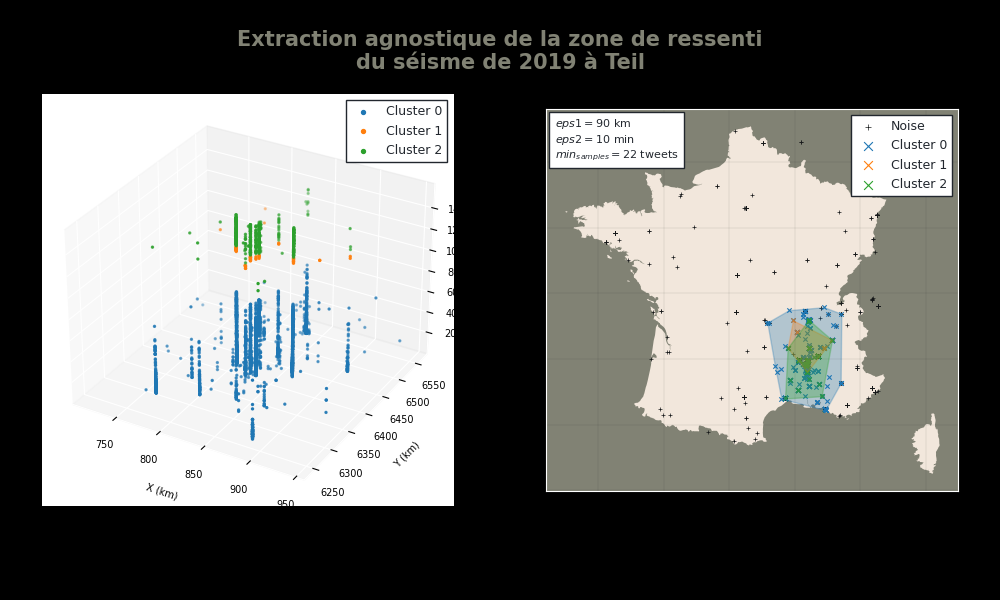

In [5]:
# Plot space time cube
plot_cube_hulls(tweets=tweets, eps1_terrain=eps1_terrain, eps2=eps2, hulls=hulls, min_samples=min_samples)

#### Convex hulls as Quake feeling areas

In order to assess the extent of the quake, we'll create a convex hull for each cluster.

In [6]:
# Export tweets to geojson
tweets.to_file(f'../data/result/tweets_stdbscan_eps1_{eps1_terrain / 1_000:.0f}_km_eps2_{int(eps2 / 60)}_min.geojson', driver='GeoJSON')

# Export hulls to geojson
hulls.to_file(f'../data/result/hulls_stdbscan_eps1_{eps1_terrain / 1_000:.0f}_km_eps2_{int(eps2 / 60)}_min.geojson', driver='GeoJSON')

> Made with ♥ by Léa, Romain and Salaheddine.